<a href="https://colab.research.google.com/github/hhkkmz/Detectron2_Food_Dataset/blob/main/Detectron2_use_pretrainedmodel_to_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 9.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=2a06747e49e66ce6f4edf6b93276e6436569062971021b95737b6942a80395fa
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 4.7MB/s 
     |████████████████████████████████| 2.2MB 8.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201204-cp36-none-any.whl size=44622 sha256=6220b324a72453fd5a49614be1ef6a55e9ff91428d1037be99487967de7e0ab4
  Stored in directory: /root/.cache/pip/wheels/b7/c9/47/dc3ce6f67e8cbfb4dec8e9ce981a2aa67b56525d7b91b510af
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


## **You should restart runtime** And then continue run the next command 


In [ ]:
from google.colab import drive #import google drive account
drive.mount('/content/gdrive')

In [1]:

# Add this file to your Google Drive Account https://drive.google.com/drive/folders/1eFwH3sZd1mw_6nSyL3VHwMohqCUM89U-?usp=sharing
!wget https://github.com/hhkkmz/Detectron2_Food_Dataset/raw/main/images.zip
!unzip /content/images.zip

--2020-12-06 15:49:39--  https://github.com/hhkkmz/Detectron2_Food_Dataset/raw/main/images.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hhkkmz/Detectron2_Food_Dataset/main/images.zip [following]
--2020-12-06 15:49:39--  https://raw.githubusercontent.com/hhkkmz/Detectron2_Food_Dataset/main/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12915071 (12M) [application/zip]
Saving to: ‘images.zip.1’

images.zip.1        100%[===================>]  12.32M  34.0MB/s    in 0.4s    

2020-12-06 15:49:40 (34.0 MB/s) - ‘images.zip.1’ saved [12915071/12915071]

Archive:  /content/images.zip
repl

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_food_dicts(directory):
    classes = ['baklava','barbunya','cipura','makarna','karides','salata','limon','sogan','biber','domates','yesilsogan','patates','turp','su','ekmek','salatalik','etsote']
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 600
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("food_" + d, lambda d=d: get_food_dicts('/content/images/' + d))
    MetadataCatalog.get("food_" + d).set(thing_classes=['baklava','barbunya','cipura','makarna','karides','salata','limon','sogan','biber','domates','yesilsogan','patates','turp','su','ekmek','salatalik','etsote'])
food_metadata = MetadataCatalog.get("food_train")

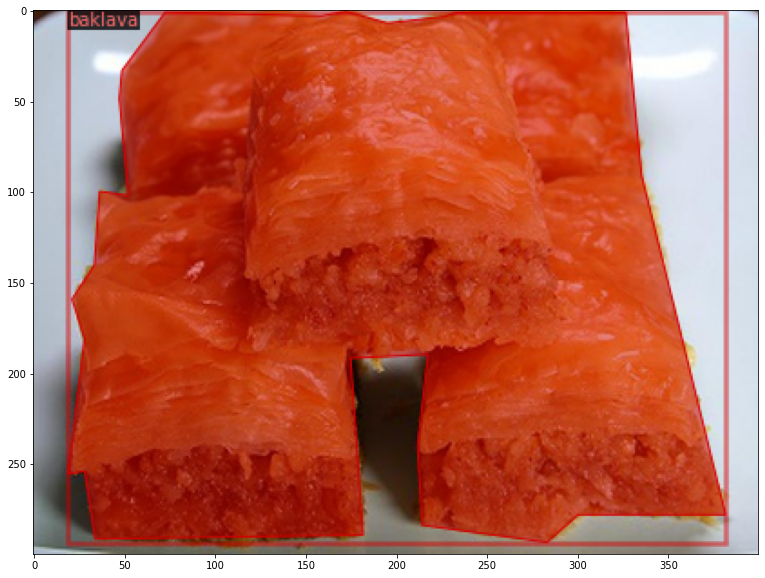

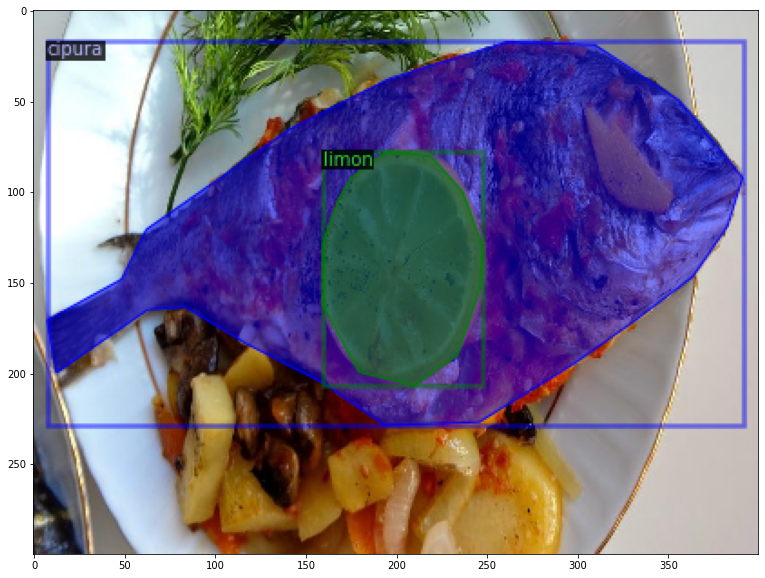

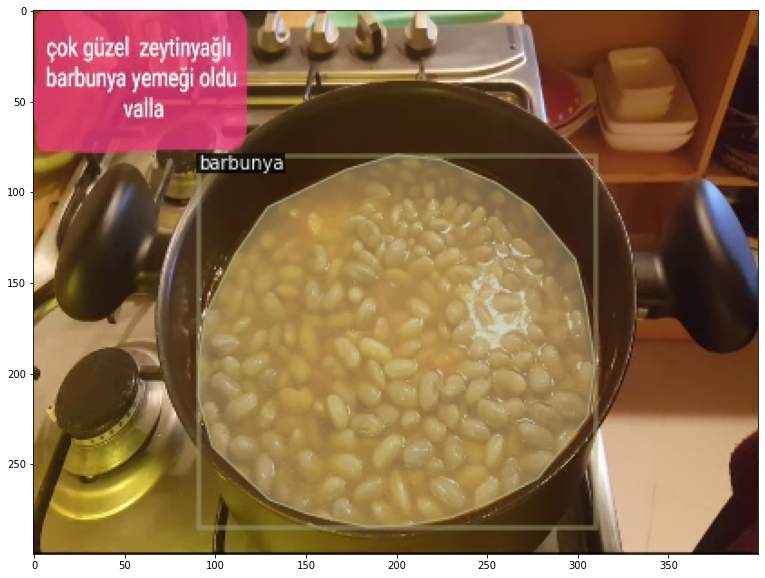

In [ ]:
import random

dataset_dicts = get_food_dicts("/content/images/test/")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    v = Visualizer(img[:, :, ::-1], metadata=food_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("food_test",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 17

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
cfg.MODEL.WEIGHTS = os.path.join("/content/gdrive/MyDrive/output/model_final.pth") #Your model files path
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("food1_test")
predictor = DefaultPredictor(cfg)

[12/04 15:43:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 94.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (18, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (68, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (68,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due 

/content/drive/MyDrive/output/model_final.pth


In [2]:
#@title Food Image URL { run: "auto" }
Image_url = "https://im.haberturk.com/2020/05/16/ver1589641211/2681846_1024x576.jpg" #@param {type:"string"}
from detectron2.utils.visualizer import ColorMode
from PIL import Image
import requests
import matplotlib.pyplot as plt

response = requests.get(Image_url, stream=True)
img = Image.open(response.raw)
img.save('img.jpg')
dataset_dicts = get_food_dicts('/content/images/test/')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread('/content/img.jpg')
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=food_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

ModuleNotFoundError: ignored